In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
import numpy as np 
import scipy.special
import scipy.fft
from operators.SW_sqrt import solve_poisson_equation, psi_ln_sw, mass, momentum, energy_k

In [4]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pl
from mycolorpy import colorlist as mcp
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Nonlinear Landau Damping SW square-root

In [5]:
# set up configuration parameters
# number of mesh points in x 
Nx = 101
# number of spectral expansions
Nv = 100
# epsilon displacement in initial electron distribution 
epsilon = 0.5
# velocity scaling of electron and ion
alpha_e = np.sqrt(2)
alpha_i = np.sqrt(2/1863)
# x grid is from 0 to L
L = 4 * np.pi
# spacial spacing dx = x[i+1] - x[i]
dx = L/(Nx-1)
# time stepping 
dt = 1e-2
# final time (nondimensional)
T = 10.
# velocity scaling 
u_e = 0
u_i = 0 
# mass normalized
m_e = 1
m_i = 1863
# charge normalized
q_e = -1
q_i = 1

In [6]:
# velocity grid for plotting purposes
v = np.linspace(-4, 4, 10000)
# spatial grid 
x = np.linspace(0, L, Nx)

In [7]:
# initial condition of the first expansion coefficient
C_0e = np.sqrt((1 + epsilon * np.cos(0.5*x)) / alpha_e)
C_0i = np.sqrt(np.ones(Nx) / alpha_i)

In [8]:
# the distribution function of electrons and protons for plotting purposes
f_0e = np.outer(C_0e, psi_ln_sw((v-u_e)/alpha_e, n=0))
f_0i = np.outer(C_0i, psi_ln_sw((v-u_i)/alpha_i, n=0))

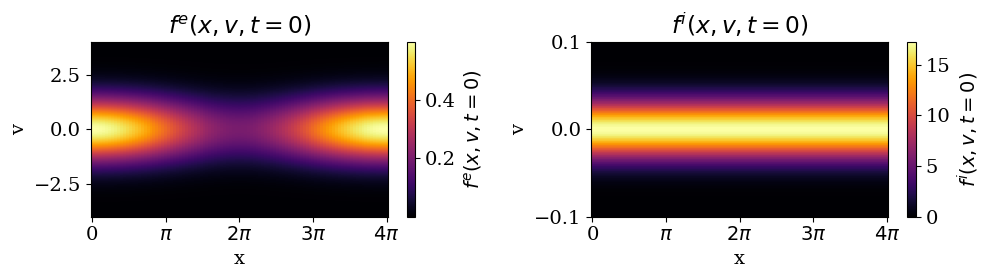

In [9]:
# plot initial condition 
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
pos = ax[0].pcolormesh(x, v, (f_0e**2).T, cmap="inferno", vmax=np.max(f_0e**2))
ax[0].set_xlabel("x")
ax[0].set_xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi])
ax[0].set_xticklabels([r"0", r"$\pi$", r"$2\pi$", r"$3\pi$", r"$4\pi$"])
ax[0].set_ylabel("v")
cbar = fig.colorbar(pos)

cbar.ax.set_ylabel('$f^{e}(x, v, t=0)$', rotation=90)
ax[0].set_title("$f^{e}(x, v, t=0)$")

pos = ax[1].pcolormesh(x, v, (f_0i**2).T, cmap="inferno")
ax[1].set_xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi])
ax[1].set_xticklabels([r"0", r"$\pi$", r"$2\pi$", r"$3\pi$", r"$4\pi$"])
ax[1].set_ylim(-0.1, 0.1)
ax[1].set_yticks([-0.1, 0, 0.1])
ax[1].set_ylabel("v")
ax[1].set_xlabel("x")
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{i}(x, v, t=0)$', rotation=90)
ax[1].set_title("$f^{i}(x, v, t=0)$")
plt.tight_layout()
plt.savefig("../figs/SW_sqrt/nonlinear_landau/initial_condition_landau_damping.png", dpi=600)

In [10]:
# initialize states (electrons and ions) 
states_e = np.zeros((Nv, Nx-1))
states_i = np.zeros((Nv, Nx-1))

In [11]:
# initialize the expansion coefficients
states_e[0, :] = C_0e[:-1]
states_i[0, :] = C_0i[:-1]

# initial condition of the semi-disretized ODE
y0 = np.append(states_e.flatten("C"), states_i.flatten("C"))
y0 = np.append(y0, 0)

In [12]:
# read in simulation data
sol_midpoint_u = np.load("../data/SW_sqrt/nonlinear_landau/sol_midpoint_u_" + str(Nv) + ".npy")
sol_midpoint_t = np.load("../data/SW_sqrt/nonlinear_landau/sol_midpoint_t_" + str(Nv) + ".npy")

# print the shape of simulation data
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(10002, 1001)
(1001,)


In [13]:
# initialize the electric potential
E_midpoint = np.zeros((Nx, len(sol_midpoint_t)))

In [ ]:
# initialize the states for implicit midpoint (symplectic)
state_e_midpoint = np.zeros((Nv, Nx-1, len(sol_midpoint_t)))
state_i_midpoint = np.zeros((Nv, Nx-1, len(sol_midpoint_t)))

for ii in range(len(sol_midpoint_t)):
    for jj in range(Nv):
        # unwind the flattening in order to solve the nonlinear system
        state_e_midpoint[jj, :, ii] = sol_midpoint_u[jj*(Nx-1): (jj+1)*(Nx-1), ii]
        # static/background ions
        state_i_midpoint[0, :, ii] = np.sqrt(np.ones(Nx - 1) / alpha_i)

    # solve Poisson equation
    E_midpoint[:-1, ii] = solve_poisson_equation(state_e=state_e_midpoint[:, :, ii], 
                                                 state_i=state_i_midpoint[:, :, ii], 
                                                 alpha_e=alpha_e, 
                                                 alpha_i=alpha_i, 
                                                 dx=dx, 
                                                 L=L)
    E_midpoint[-1, ii] = E_midpoint[0, ii]

In [ ]:
# compute the damping rate of the electric field
E1_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(len(sol_midpoint_t)):
    E1_midpoint[ii] = np.abs(scipy.fft.fft(E_midpoint[:, ii]))[1]

In [ ]:
# plot electric field evolution 
fig, ax = plt.subplots(figsize=(6, 4.5))
colors = pl.cm.viridis(np.linspace(0,1,len(sol_midpoint_t)//100 + 1))

for kk, ii in enumerate(range(0, len(sol_midpoint_t), 100)):
    _ = plt.plot(x, E_midpoint[:, ii], c=colors[kk], label=r"$E(x, t=$" + str(round(sol_midpoint_t[ii], 2)) + ")")
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=10, loc=(1, 0))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
legend.get_frame().set_alpha(0)
ax.set_xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi])
ax.set_xlim(0, 4*np.pi)
ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$",  r"$3\pi$",  r"$4\pi$"])
ax.set_xlabel("$x$")
ax.set_ylabel("$E(x, t)$")
plt.tight_layout()
plt.savefig("../figs/SW_sqrt/nonlinear_landau/sw_sqrt_electric_field.png", dpi=600)

In [ ]:
# plot damping rate
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sol_midpoint_t, E1_midpoint, "-", c="purple", alpha=0.5, linewidth=3, label="Implicit Midpoint") 
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(1)|$")
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/SW_sqrt/nonlinear_landau/damping_rate_electric_field.png", dpi=600)

In [ ]:
# plot phase space evolution 
label_list = ["0", "2.5", "5", "7.5", "10"]
fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(6, 12))
for tt, ii in enumerate(range(0, len(sol_midpoint_t), int(len(sol_midpoint_t)/4))):
    distribution = np.zeros((Nx, len(v)))
    for jj in range(Nv):
        distribution += np.outer(np.append(state_e_midpoint[jj, :, ii], state_e_midpoint[jj, 0, ii]), psi_ln_sw((v)/alpha_e, n=jj))
    levels = np.append(-0.1, np.linspace(0, 0.65, 15))[:-1]
    colors = mcp.gen_color(cmap="inferno",n=len(levels)-1)[:-1]
    pos = ax[tt].contourf(x, v, (distribution**2).T, levels=levels, colors=np.append(["w"], colors))
    ax[tt].set_xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi])
    ax[tt].set_xticklabels([r"0", r"$\pi$", r"$2\pi$", r"$3\pi$", r"$4\pi$"])
    ax[tt].set_ylabel("v")
    cbar = fig.colorbar(pos)
    ax[tt].set_title("$f^{e}(x, v, t=$" + str(label_list[tt]) + ")", fontsize=14)
    cbar.ax.set_yticks([0, 0.2, 0.4, 0.6])
    cbar.ax.set_yticklabels(["0", "0.2", "0.4", "0.6"])
ax[-1].set_xlabel("x")
plt.tight_layout()
plt.savefig("../figs/SW_sqrt/nonlinear_landau/nonlinear_landau_evolution_SW_sqrt_" + str(Nv) + ".png", dpi=600)

In [ ]:
# plot the electron particle distribution function at the last timestamp
fig, ax = plt.subplots(figsize=(6, 3))
distribution = np.zeros((Nx, len(v)))
for jj in range(Nv):
    distribution += np.outer(np.append(state_e_midpoint[jj, :, -1], state_e_midpoint[jj, 0, -1]), psi_ln_sw((v-u_e)/alpha_e, n=jj))
pos = ax.pcolormesh(x, v, (distribution**2).T, cmap="magma")
ax.set_xlabel("x")
ax.set_xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi])
ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$", r"$3\pi$", r"$4\pi$"])
ax.set_ylabel("v")
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{e}(x, v, t=$' + str(round(sol_midpoint_t[-1], 2)) + ")", rotation=90)
#cbar.ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

plt.tight_layout()
#plt.savefig("../figs/SW_sqrt/nonlinear_landau/poisson/nonlinear_landau_distribution_t_10.png", dpi=600)

In [19]:
# save the distribution function at the last timestamp
np.save("../data/SW_sqrt/nonlinear_landau/sw_sqrt_landau_distribution_Nv_" +str(Nv)+ ".npy", distribution**2)

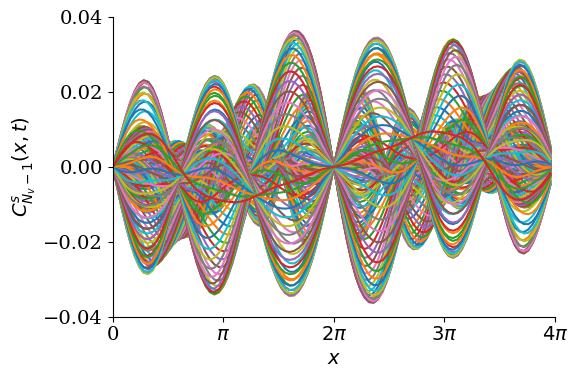

In [20]:
# plot the evolution of the last coefficient
fig, ax = plt.subplots(figsize=(6, 4))
_ = plt.plot(x[:-1], state_e_midpoint[-1, :, ::3])
ax.set_xlabel("$x$")
ax.set_ylabel("$C_{N_{v}-1}^{s}(x, t)$")
ax.set_xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi])
ax.set_yticks([-0.04, -0.02, 0, 0.02, 0.04])
ax.set_xlim(0, 4*np.pi)
ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$", r"$3\pi$", r"$4\pi$"])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig("../figs/SW_sqrt/nonlinear_landau/last_coefficient_central.png")

# conservation laws: mass, momentum, and energy

### mass conservation

In [21]:
# compute mass evolution 
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = mass(state=state_e_midpoint[:, :, ii], alpha_s=alpha_e, dx=dx, Nv=Nv)\
                      + mass(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, dx=dx, Nv=Nv)

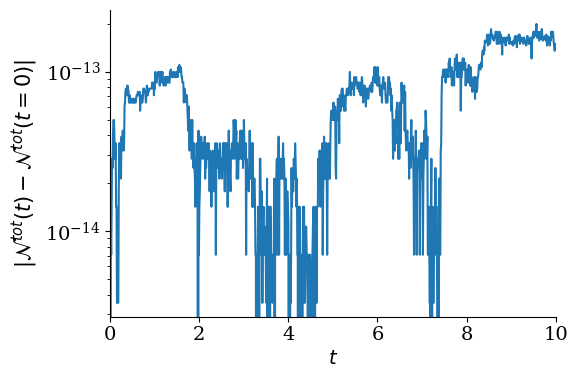

In [22]:
# plot mass evolution 
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "-")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{N}^{tot}(t) - \mathcal{N}^{tot}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
plt.tight_layout()

### momentum conservation

In [23]:
# momentum evolution 
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = momentum(state=state_e_midpoint[:, :, ii], alpha_s=alpha_e, dx=dx, Nv=Nv, u_s=u_e, m_s=m_e)\
                           +momentum(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, dx=dx, Nv=Nv, u_s=u_i, m_s=m_i)

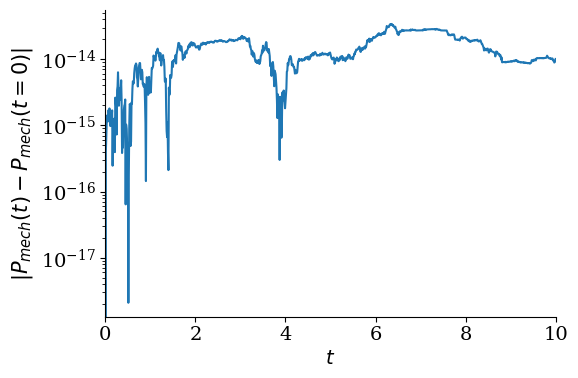

In [24]:
# plot momentum evolution 
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t$")
ax.set_xlim(0, T)
plt.tight_layout()

### energy conservation

In [25]:
# compute kinetic + potential energy evolution 
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = energy_k(state=state_e_midpoint[:, :, ii], Nv=Nv, alpha_s=alpha_e, m_s=m_e, dx=dx, u_s=u_e)\
                           +energy_k(state=state_i_midpoint[:, :, ii], Nv=Nv, alpha_s=alpha_i, m_s=m_i, dx=dx, u_s=u_i)
    
    energy_p_midpoint[ii] = 0.5*dx*np.sum((E_midpoint[:-1, ii])**2)

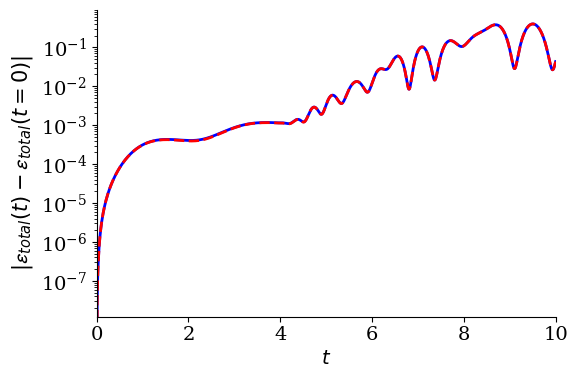

In [26]:
# plot energy evolution 
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-", color="blue", linewidth=2, label="numerical")
ax.plot(sol_midpoint_t, sol_midpoint_u[-1, :], ls="--", color="red", linewidth=2, label="analytic")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
ax.set_yscale("log")
plt.tight_layout()

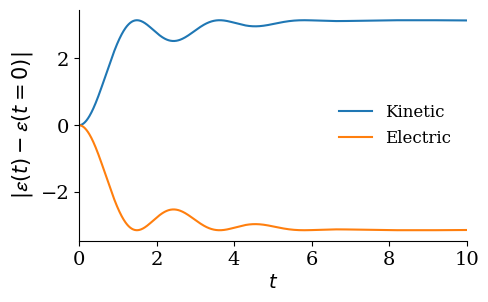

In [27]:
# plot energy exchange 
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(sol_midpoint_t, energy_k_midpoint - energy_k_midpoint[0] - sol_midpoint_u[-1, :], label="Kinetic")
ax.plot(sol_midpoint_t, energy_p_midpoint - energy_p_midpoint[0], label="Electric")
ax.set_ylabel(r"$|\mathcal{\epsilon}(t)-\mathcal{\epsilon}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0, 10)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12)
legend.get_frame().set_alpha(0)
plt.savefig("../figs/SW_sqrt/nonlinear_landau/energy_transfer.png", dpi=600)

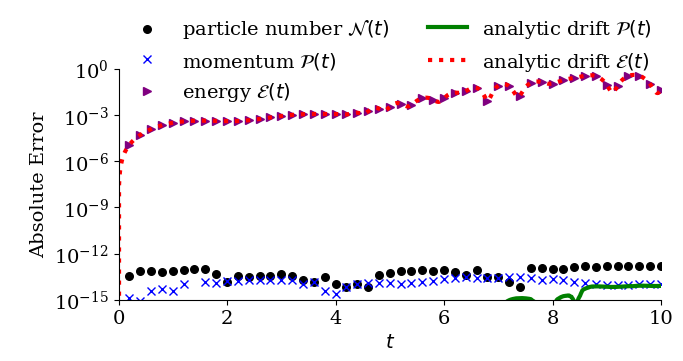

In [28]:
# plot overall conservation properties
fig, ax = plt.subplots(ncols=1, figsize=(7, 3))

ax.scatter(sol_midpoint_t[::20], np.abs(mass_midpoint-mass_midpoint[0])[::20], s=30, color="black", label=r"particle number $\mathcal{N}(t)$")
ax.plot(sol_midpoint_t[::20], np.abs(momentum_midpoint-momentum_midpoint[0])[::20], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::20], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::20], ">", color="purple", label=r"energy $\mathcal{E}(t)$")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-2]), "-", c="green", linewidth=3, label=r"analytic drift $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-1]), ":", c="red", linewidth=3, label=r"analytic drift $\mathcal{E}(t)$")
ax.set_ylim(10**-15, 10**0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
ax.set_yscale("log")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.3))
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
plt.savefig("../figs/SW_sqrt/nonlinear_landau/conservation_" + str(Nv) + "_nonlinear_landau_SW_sqrt.png", bbox_extra_artists=(legend,text), bbox_inches='tight', dpi=600)